## import

In [9]:
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
import pandas as pd
import time
from tqdm import tqdm 

## Scraping (Jia Xiang & Kesh)

In [7]:
# Step 1
driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
driver.get('https://www.imdb.com/title/tt6208148/reviews/?ref_=tt_urv')
driver.implicitly_wait(10)

# Click All
try:
    all_button = WebDriverWait(driver, 5).until(
        EC.element_to_be_clickable((By.XPATH, "//button[.//span[@class='ipc-see-more__text' and text()='All']]"))
    )
    driver.execute_script("arguments[0].click();", all_button)
    time.sleep(2)  
except:
    pass  

# Scroll to load all 
count = 0
scroll = 0

while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  
    
    mains = driver.find_elements(By.CLASS_NAME, "ipc-list-card__content")
    
    if len(mains) == count: 
        scroll += 1
        if scroll > 5:  
            break  
    else:
        scroll = 0  
    
    count = len(mains)

# Scroll again for final check
for _ in range(3):  
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  

# Review and rating
mains = driver.find_elements(By.CLASS_NAME, "ipc-list-card__content")
all_reviews = []
all_ratings = []


for main in tqdm(mains):
    # Review
    ret = main.find_elements(By.CLASS_NAME, "ipc-html-content-inner-div")
    review = ret[0].text.strip() if ret else ""  

    # Rating
    rat = main.find_elements(By.CLASS_NAME, "sc-3e6f8aa9-4")
    rating = f"{rat[0].text.strip().split('\n')[0]}/10" if rat else ""  

    all_reviews.append(review)
    all_ratings.append(rating)

imdb = {
    'Review': all_reviews,
    'Rating': all_ratings,
}

# CSV
df = pd.DataFrame(imdb)
df.fillna("", inplace=True)  
df.to_csv('imdb.csv', index=False)
driver.quit()
df

100%|██████████| 1194/1194 [22:32<00:00,  1.13s/it]


,Review,Rating
0,Disney's live-action Snow White is finally her...,1/10
1,"As always, whenever there's a negative hype ar...",1/10
2,"Disney's latest live-action remake, Snow White...",1/10
3,Saw this at the cinema with my six-year-old da...,1/10
4,Snow White remake set out to modernize the cla...,1/10
...,...,...
1189,As someone who never cared much for the origin...,9/10
1190,"I have seen bad movies before, but this one ta...",1/10
1191,,7/10
1192,I viewed Snow White this weekend and found it ...,10/10


## Data Cleaning and Sentiment Analysis (Thaddeus)

In [11]:
df = pd.read_csv('./imdb.csv')
df.head()

,Review,Rating
0,Disney's live-action Snow White is finally her...,1/10
1,"As always, whenever there's a negative hype ar...",1/10
2,"Disney's latest live-action remake, Snow White...",1/10
3,Saw this at the cinema with my six-year-old da...,1/10
4,Snow White remake set out to modernize the cla...,1/10


In [13]:
import nltk
nltk.__version__
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

In [14]:
nltk.download('punkt_tab') # for tokenisation
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng') # POS tagging Part of speech tagging
nltk.download('wordnet') # lemmatization
nltk.download('vader_lexicon') # sentiment analysis

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/thaddeusteh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thaddeusteh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/thaddeusteh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thaddeusteh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/thaddeusteh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
## preps data to be run thru sentiment analysis
def preprocess (data):
    words = word_tokenize(data)
    stop_words = set(stopwords.words('english'))
    normalize_words = [word.lower() for word in words if word.isalpha()]
    filtered_words = [word for word in normalize_words if word not in stop_words]
    text = ' '.join(filtered_words)
    return text

In [19]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiments(df):
    # default vals
    df['Cleaned_Review'] = ''
    df['VADER_Compound'] = 0.0
    df['VADER_Positive'] = 0.0
    df['VADER_Negative'] = 0.0
    df['VADER_Neutral'] = 0.0
    
    # processing review
    for i in range(len(df)):
        review_text = df.loc[i, 'Review']
    # make to empty string (if not: float error)
        if type(review_text) != str:
            review_text = ""
        
        # cuci before analyze
        clean = preprocess(review_text)
        #print(clean_review)
        df.at[i, 'Cleaned_Review'] = clean
        # sentiment analysis
        sentiment_scores = sia.polarity_scores(clean)
        df.at[i, 'VADER_Compound'] = sentiment_scores['compound']
        df.at[i, 'VADER_Positive'] = sentiment_scores['pos']
        df.at[i, 'VADER_Negative'] = sentiment_scores['neg']
        df.at[i, 'VADER_Neutral'] = sentiment_scores['neu']

    file = 'imdb_sentiment_analysis.csv'
    df.to_csv(file, index=False)
    print(f"done, saved to {file}.")

    return df


In [21]:
df = analyze_sentiments(df)

done, saved to imdb_sentiment_analysis.csv.


## Word Cloud (KXLeong)

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

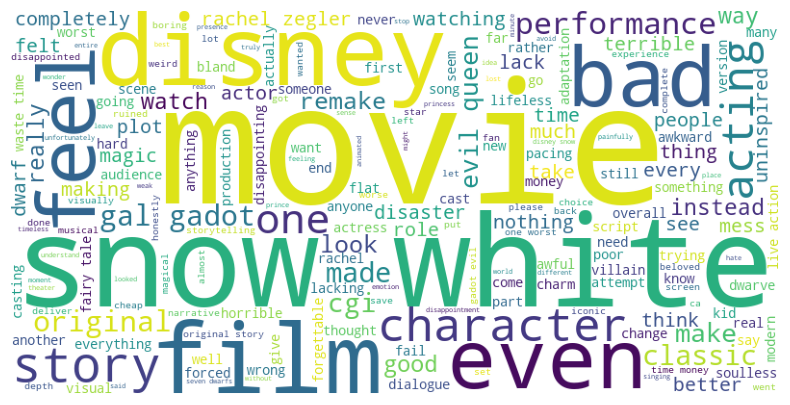

In [24]:
wc = WordCloud(width=800,height=400,background_color='white').generate(' '.join(df[df['VADER_Compound'] <= -0.05]['Cleaned_Review'].values))
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.show()

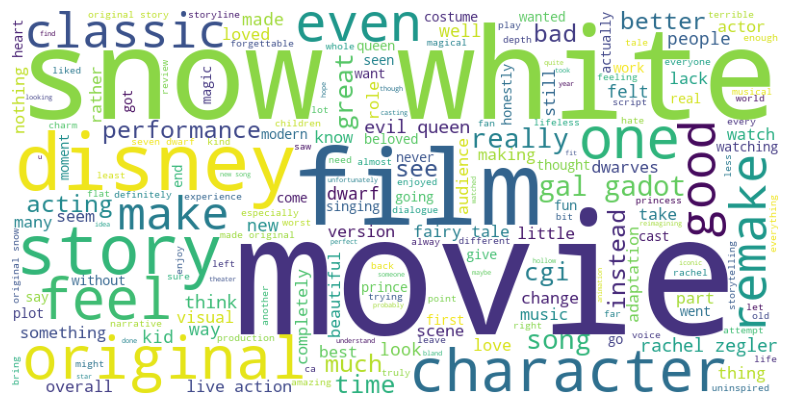

In [27]:
wc = WordCloud(width=800,height=400,background_color='white').generate(' '.join(df[df['VADER_Compound'] >= 0.05]['Cleaned_Review'].values))
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.show()

## Sentiment distribution 

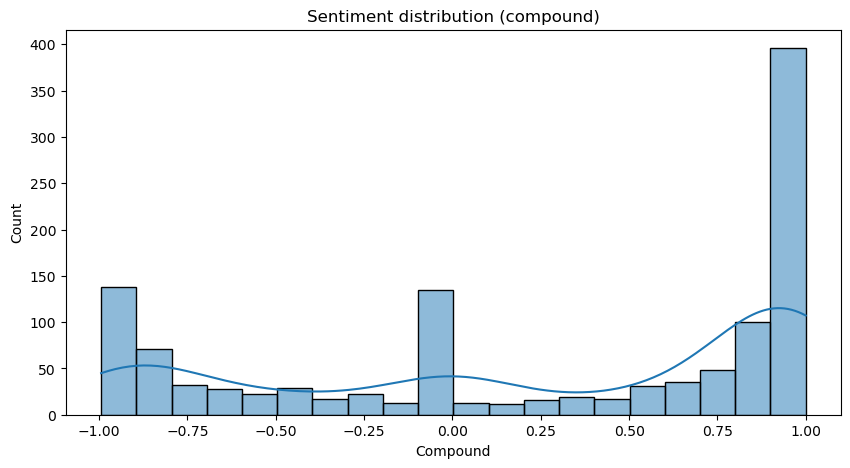

In [53]:
plt.figure(figsize=(10,5))
sns.histplot(df['VADER_Compound'], bins=20, edgecolor='black', kde=True)
plt.title('Sentiment distribution (compound)')
plt.xlabel('Compound')
plt.show()

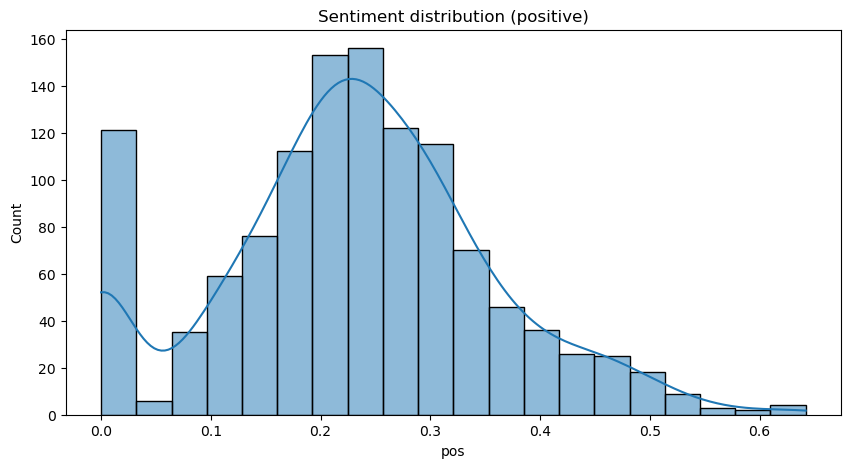

In [51]:
plt.figure(figsize=(10,5))
sns.histplot(df['VADER_Positive'], bins=20, edgecolor='black', kde=True)
plt.title('Sentiment distribution (positive)')
plt.xlabel('pos')
plt.show()

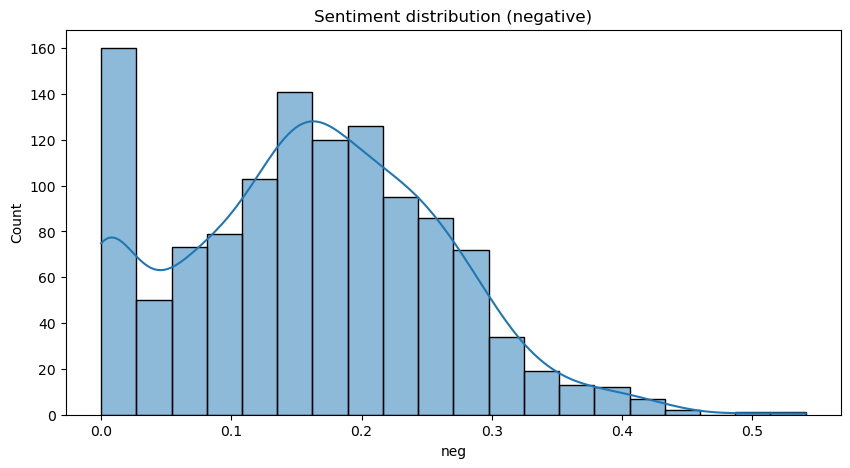

In [49]:
plt.figure(figsize=(10,5))
sns.histplot(df['VADER_Negative'], bins=20, edgecolor='black', kde=True)
plt.title('Sentiment distribution (negative)')
plt.xlabel('neg')
plt.show()

## Standard deviation

In [133]:
import numpy as np  

# Make it to float and drop '' data
df['New_Rating'] = df['Rating'].str.replace('/10', "", regex=True).astype(float)
sd = np.std(df['New_Rating'].dropna())
sd

3.122885069946158

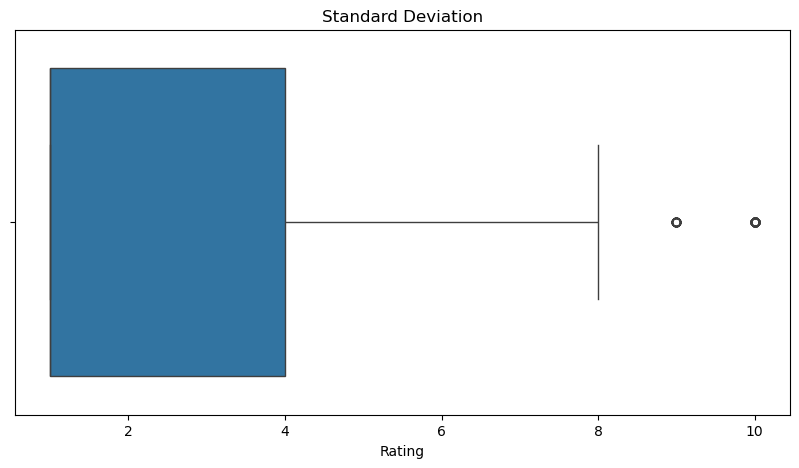

In [187]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['New_Rating'])
plt.title('Standard Deviation')
plt.xlabel('Rating')
plt.show()


## Normal distribution

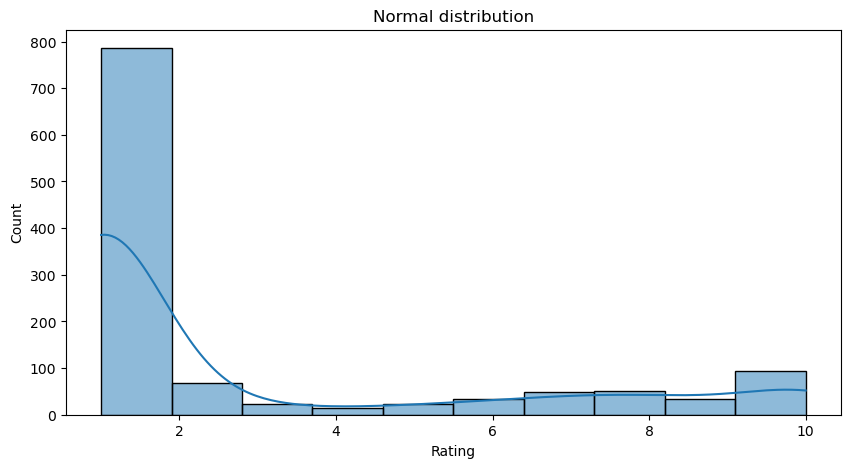

In [200]:
plt.figure(figsize=(10,5))
sns.histplot(df['New_Rating'], bins=10, kde='True', edgecolor='black')
plt.title('Normal distribution')
plt.xlabel('Rating')
plt.show()

## Ratio

In [146]:
import math

# Positve (6-10) and negative reviews (1-5)
pr = (df['New_Rating'] >= 6).sum() 
nr = (df['New_Rating'] <= 5).sum()  

# Avoid division by zero
if pr > 0:
    # Round the ratio
    ratio = nr // pr 
    zzz = f"{nr}:{pr}"  
else:
    zzz = 'Nothing here...'

zzz

'916:261'

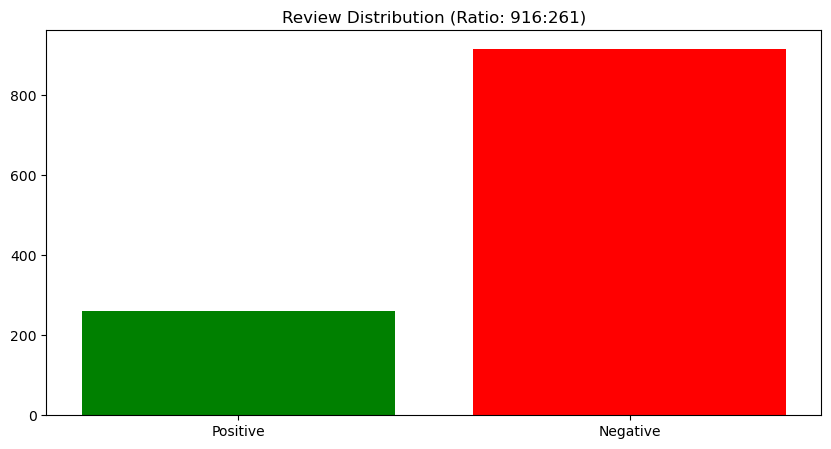

In [157]:
review = ['Positive', 'Negative']
values = [pr, nr]

plt.figure(figsize=(10, 5))
plt.bar(review, values, color=['green', 'red'])
plt.title(f"Review Distribution (Ratio: {zzz})")
plt.show()